strategy: use as many features as possible to not complicate the prediction process

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [37]:
import joblib 
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

1. Reading the dataset

In [38]:
path = r'../dataset/gold_data_20_y_cleaned.csv'    
df = pd.read_csv(path, parse_dates=['Date'])
df = df.sort_values("Date")
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Date,IR14270,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,Open sp500,High sp500,Low sp500,Close sp500,Volume sp500,Open usd_index,High usd_index,Low usd_index,Close usd_index
0,2000-08-30,10.4,273.899994,273.899994,273.899994,273.899994,0.0,172.7,6.50,1509.839966,1510.489990,1500.089966,1502.589966,8.184000e+08,112.190002,112.779999,112.110001,112.139999
1,2000-08-31,10.4,274.799988,278.299988,274.799988,278.299988,0.0,172.7,6.50,1502.589966,1525.209961,1502.589966,1517.680054,1.056600e+09,111.980003,112.930000,111.779999,112.599998
2,2000-09-01,10.2,277.000000,277.000000,277.000000,277.000000,0.0,173.6,6.52,1517.680054,1530.089966,1515.530029,1520.770020,7.677000e+08,112.360001,112.599998,111.250000,111.419998
3,2000-09-05,10.2,275.799988,275.799988,275.799988,275.799988,2.0,173.6,6.52,1520.770020,1520.770020,1504.209961,1507.079956,8.385000e+08,111.610001,112.769997,111.500000,112.410004
4,2000-09-06,10.2,274.200012,274.200012,274.200012,274.200012,0.0,173.6,6.52,1507.079956,1512.609985,1492.119995,1492.250000,9.951000e+08,112.449997,114.239998,112.320000,114.120003


2. Decreasing number of features

In [39]:
df.columns

Index(['Date', 'IR14270', 'Open', 'High', 'Low', 'Close', 'Volume', 'CPIAUCSL',
       'FEDFUNDS', 'Open sp500', 'High sp500', 'Low sp500', 'Close sp500',
       'Volume sp500', 'Open usd_index', 'High usd_index', 'Low usd_index',
       'Close usd_index'],
      dtype='object')

In [40]:
for_dropping = [
    'Open sp500', 'High sp500', 'Low sp500','Volume sp500', 'Open usd_index', 'High usd_index', 'Low usd_index', 'IR14270'
]

df = df.drop(columns=for_dropping)

In [41]:
df['sp500'] = df['Close sp500']
df['usd_index'] = df['Close usd_index']

for_drop = ['Close sp500', 'Close usd_index']
df = df.drop(columns=for_drop)

df.head()

,Date,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,0.0,172.7,6.50,1502.589966,112.139999
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,0.0,172.7,6.50,1517.680054,112.599998
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,0.0,173.6,6.52,1520.770020,111.419998
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,2.0,173.6,6.52,1507.079956,112.410004
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,0.0,173.6,6.52,1492.250000,114.120003


In [42]:
cols = ['Open', 'High', 'Low']

for col in cols: 
    df[f'{col}_prev'] = df[col].shift(1)

df.head()

,Date,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,0.0,172.7,6.50,1502.589966,112.139999,NaN,NaN,NaN
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,0.0,172.7,6.50,1517.680054,112.599998,273.899994,273.899994,273.899994
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,0.0,173.6,6.52,1520.770020,111.419998,274.799988,278.299988,274.799988
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,2.0,173.6,6.52,1507.079956,112.410004,277.000000,277.000000,277.000000
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,0.0,173.6,6.52,1492.250000,114.120003,275.799988,275.799988,275.799988


In [43]:
df = df.drop(columns=cols)
df = df.dropna()

df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev
1,2000-08-31,278.299988,0.0,172.7,6.50,1517.680054,112.599998,273.899994,273.899994,273.899994
2,2000-09-01,277.000000,0.0,173.6,6.52,1520.770020,111.419998,274.799988,278.299988,274.799988
3,2000-09-05,275.799988,2.0,173.6,6.52,1507.079956,112.410004,277.000000,277.000000,277.000000
4,2000-09-06,274.200012,0.0,173.6,6.52,1492.250000,114.120003,275.799988,275.799988,275.799988
5,2000-09-07,274.000000,125.0,173.6,6.52,1502.510010,113.650002,274.200012,274.200012,274.200012


In [44]:
path = r'../dataset/dataset_v2.csv'

df.to_csv(path, index=False)

3. Scaling values

In [45]:
target = ['Close']
features = [col for col in df.columns if col not in ['Date', target]]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

path = r'../scalers/scaler2.pkl'
joblib.dump(scaler, path)

['../scalers/scaler2.pkl']

In [46]:
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev
1,2000-08-31,0.007305,0.000000,0.000000,0.996909,0.153842,0.832560,0.005930,0.005512,0.005996
2,2000-09-01,0.006895,0.000000,0.006086,1.000000,0.154407,0.808755,0.006213,0.006874,0.006281
3,2000-09-05,0.006517,0.000005,0.006086,1.000000,0.151903,0.828727,0.006903,0.006472,0.006979
4,2000-09-06,0.006014,0.000000,0.006086,1.000000,0.149191,0.863224,0.006527,0.006100,0.006598
5,2000-09-07,0.005951,0.000324,0.006086,1.000000,0.151068,0.853742,0.006024,0.005605,0.006091


4. Training XGB model

In [47]:
X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [48]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [49]:
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R² Score: -0.3996
Mean Squared Error: 0.0233


In [50]:
path = r'../models/model2.pkl'
joblib.dump(xgb, path)

['../models/model2.pkl']

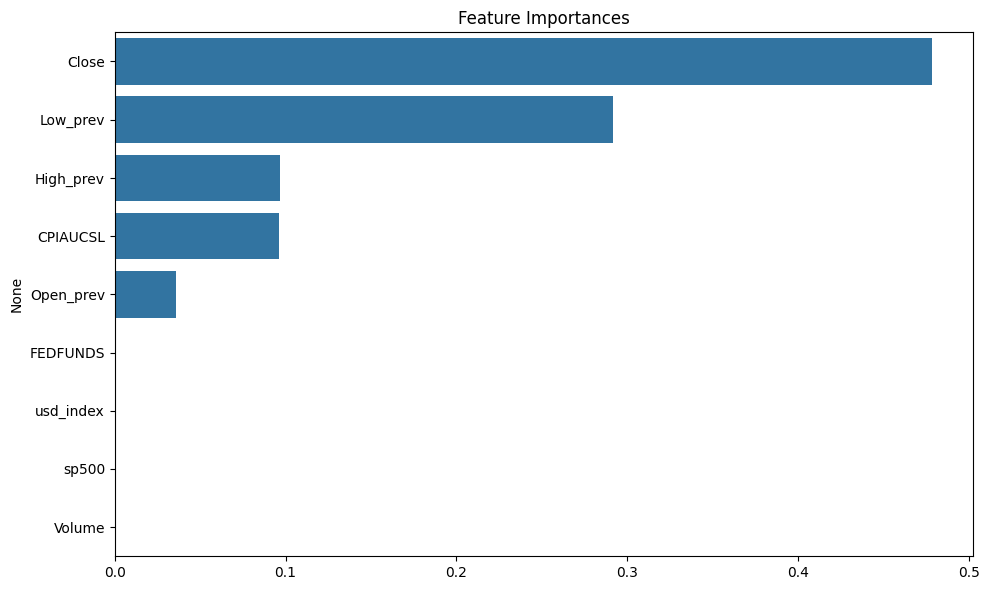

In [51]:
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

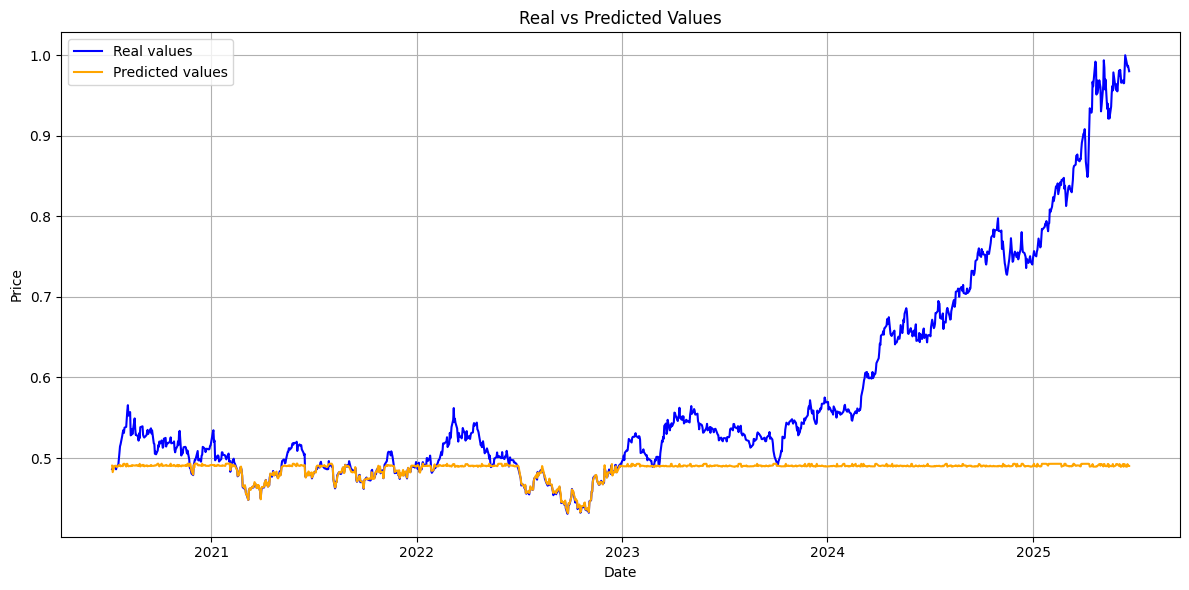

In [52]:
df['Date'] = pd.to_datetime(df['Date'])

date_test = df['Date'].iloc[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(date_test, y_test, label='Real values', color='blue')
plt.plot(date_test, y_pred, label='Predicted values', color='orange')

plt.title('Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
